## Covid -19 Data Analysis with Mask Mandates and Compliance into Consideration

The purpose of this notebook is to analyze the effect of masking policies and the compliance of these policies amomg the population at Franklin in Ohio in United States during COVID-19 for the time spaen between February 1, 2020 through October 1, 2021. The data sets used for this analysis are curated from the below mentioned links.
1. [John Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university)
2. [masking mandates by county](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i)
3. [mask compliance survey](https://github.com/nytimes/covid-19-data/tree/master/mask-use)



# Table of Contents

1. Step 1 : Data Acquisition - collecting data from the above mentioned links
2. Step 2 : Data Processing - involves steps that do data cleansing and manipulation
3. Step 3 : Analysis - to answer the specific questions

### Step 1 :Data Acquisition - collecting data from the above mentioned links

#### Importing the Python packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import os
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.simplefilter("ignore", UserWarning)



#### Importing RAW_us_confirmed_cases.csv
- This data ([John Hopkins University COVID-19 data](https://www.kaggle.com/datasets/antgoldbloom/covid19-data-from-john-hopkins-university)) contains the number of infections in the United States for each state captured on daily basis 

In [3]:
PATH = os.getcwd()
DATA_PATH = r'/Users/qwert/Documents/UW_Data_Science/Human_Centered_Data_Science/Homeworks/Course_Project/raw_data/'


In [4]:
df_raw_us_confirmed_cases = pd.read_csv(DATA_PATH + 'RAW_us_confirmed_cases.csv')
df_raw_us_confirmed_cases.head(3)


,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/20/22,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18480,18480,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65895,65895,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6926,6926,6930,6930,6930


#### Data Filtering - Franklin in Ohio state
 - Our analyis in this notebook is only for Franklin in Ohio 

In [5]:
df_raw_us_Ohio = df_raw_us_confirmed_cases[df_raw_us_confirmed_cases['Province_State']=='Ohio']

df_raw_us_Ohio_Franklin_row = df_raw_us_Ohio[df_raw_us_Ohio['Admin2']=='Franklin']

df_raw_us_Ohio_Franklin_row.head(3)

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/20/22,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22
2148,Ohio,Franklin,84039049,US,USA,840,39049.0,US,39.969958,-83.011158,...,344061,344061,344061,344061,344061,344061,344061,345102,345102,345102


#### Dropping the non-necessary columns 


In [8]:
df_Franklin_in_Ohio_row = df_raw_us_Ohio_Franklin_row.drop(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], axis=1)
df_Franklin_in_Ohio_row.tail(3)


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,10/20/22,10/21/22,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22
2148,0,0,0,0,0,0,0,0,0,0,...,344061,344061,344061,344061,344061,344061,344061,345102,345102,345102


#### Converting the row dates into column dates 

In [10]:
df_Franklin_in_Ohio = df_Franklin_in_Ohio_row.melt(id_vars=[],var_name="Date",value_name="Infections")
df_Franklin_in_Ohio.rename(columns = {'Date':'date'}, inplace = True)
df_Franklin_in_Ohio.tail(5)


,date,Infections
1007,10/25/22,344061
1008,10/26/22,344061
1009,10/27/22,345102
1010,10/28/22,345102
1011,10/29/22,345102


#### Loading Mask Mandate Data
The data has been downloaded from [masking mandates by county](https://data.cdc.gov/Policy-Surveillance/U-S-State-and-Territorial-Public-Mask-Mandates-Fro/62d6-pm5i) which contains the mask mandate information for the countries in the United States

In [3]:
raw_csv_public_mask_mandate = pd.read_csv('/Users/qwert/Documents/UW_Data_Science/Human_Centered_Data_Science/Homeworks/US_State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv')

df_mask_Franklin = raw_csv_public_mask_mandate[raw_csv_public_mask_mandate['State_Tribe_Territory']=='OH']
df_mask_Franklin = df_mask_Franklin[df_mask_Franklin['County_Name']=='Franklin County']

df_mask_Franklin.columns


#### Dropping the non-necessary columns not required for analysis from the dataframe

In [4]:
df_comp_mask = df_mask_Franklin.drop(['State_Tribe_Territory', 'County_Name', 'FIPS_State', 'FIPS_County', 'order_code', 'Source_of_Action', 'URL', 'Citation'], axis=1)



#### Counting the number of mandates(Yes/No) in comp_mask dataframe

In [5]:
df_comp_mask.Face_Masks_Required_in_Public.value_counts()

Yes    329
No      75
Name: Face_Masks_Required_in_Public, dtype: int64

#### Filling the NA's in dataframe with No. My assumption here is that when no value is present in the mandate column, mask mandate was not there in place

In [8]:
df_comp_mask.Face_Masks_Required_in_Public.fillna("No", inplace = True)
df_comp_mask.Face_Masks_Required_in_Public.value_counts()

Yes    329
No     164
Name: Face_Masks_Required_in_Public, dtype: int64

#### Converting the date column to datetime format

In [1]:
df_Franklin_in_Ohio['date'] = pd.to_datetime(df_Franklin_in_Ohio['date'])

df_comp_mask['date'] = pd.to_datetime(df_comp_mask['date'])

#### Merging the two dataframes (mask mandate dataframe and confirmed infections dataframe)

In [12]:
df_combined = pd.merge_ordered(df_Franklin_in_Ohio, df_comp_mask, how='left', on="date")

### Step 2 : Data Processing - involves steps that do data cleansing and manipulation

#### Counting the number of Yes/No in the resultanat dataframe after merging

In [13]:
df_combined.Face_Masks_Required_in_Public.value_counts()

Yes    329
No     164
Name: Face_Masks_Required_in_Public, dtype: int64

In [14]:
df_combined.Face_Masks_Required_in_Public.isna().sum()
df_combined.head(10)

,date,Infections,Face_Masks_Required_in_Public
0,2020-01-22,0,NaN
1,2020-01-23,0,NaN
2,2020-01-24,0,NaN
3,2020-01-25,0,NaN
4,2020-01-26,0,NaN
5,2020-01-27,0,NaN
6,2020-01-28,0,NaN
7,2020-01-29,0,NaN
8,2020-01-30,0,NaN
9,2020-01-31,0,NaN


In [15]:
df_combined.Face_Masks_Required_in_Public.value_counts()

Yes    329
No     164
Name: Face_Masks_Required_in_Public, dtype: int64

#### Filling the NAs in the merged dataframe (df_combined) by using the back fill methodolgy

In [16]:
df_combined.Face_Masks_Required_in_Public = df_combined.Face_Masks_Required_in_Public.fillna(method = 'bfill')

#### Filling the NAs in the merged dataframe (df_combined) by using the forward fill methodolgy

In [17]:
df_combined.Face_Masks_Required_in_Public = df_combined.Face_Masks_Required_in_Public.fillna(method = 'ffill')

#### Checking if the back fill and forward fill has been succesfully applied

In [18]:
df_combined.Face_Masks_Required_in_Public.value_counts()

No     683
Yes    329
Name: Face_Masks_Required_in_Public, dtype: int64

#### Creating the delay for the date colum. The delay I have taken in account is for 3 days

In [19]:
df_combined['test_date'] = df_combined['date'] - timedelta(days=3)

#### Mapping  Yes/No to binary values(1/0) for model building in later part of the notebook

In [20]:
df_combined['Face_Masks_Required_in_Public'] = df_combined['Face_Masks_Required_in_Public'].map({'Yes':1, 'No':0})

In [21]:
df_combined['policy_day'] = df_combined['Face_Masks_Required_in_Public'].cumsum()

In [22]:
df_combined['days'] = np.arange(1,len(df_combined)+1)
df_combined.head(10)

,date,Infections,Face_Masks_Required_in_Public,test_date,policy_day,days
0,2020-01-22,0,0,2020-01-19,0,1
1,2020-01-23,0,0,2020-01-20,0,2
2,2020-01-24,0,0,2020-01-21,0,3
3,2020-01-25,0,0,2020-01-22,0,4
4,2020-01-26,0,0,2020-01-23,0,5
5,2020-01-27,0,0,2020-01-24,0,6
6,2020-01-28,0,0,2020-01-25,0,7
7,2020-01-29,0,0,2020-01-26,0,8
8,2020-01-30,0,0,2020-01-27,0,9
9,2020-01-31,0,0,2020-01-28,0,10


#### Filling all NaN with 0 assuming that there was no policy mandate in place for those days

In [23]:
df_combined.Infections = df_combined.Infections.replace({'0':np.nan, 0:np.nan})

#### Filling all the NA's in Infection column with back fill methodolgy

In [24]:
df_combined.Infections = df_combined.Infections.fillna(method = 'bfill')

In [25]:
df_combined.head(10)

,date,Infections,Face_Masks_Required_in_Public,test_date,policy_day,days
0,2020-01-22,1.0,0,2020-01-19,0,1
1,2020-01-23,1.0,0,2020-01-20,0,2
2,2020-01-24,1.0,0,2020-01-21,0,3
3,2020-01-25,1.0,0,2020-01-22,0,4
4,2020-01-26,1.0,0,2020-01-23,0,5
5,2020-01-27,1.0,0,2020-01-24,0,6
6,2020-01-28,1.0,0,2020-01-25,0,7
7,2020-01-29,1.0,0,2020-01-26,0,8
8,2020-01-30,1.0,0,2020-01-27,0,9
9,2020-01-31,1.0,0,2020-01-28,0,10


#### The dates we are interested for the analysis are
- start_date = '2020-02-01' - 254
- end_date   = '2021-10-01' - 619


#### Dropping the date and test_date from the dataframe

In [26]:
df_combined = df_combined.drop(['date', 'test_date'], axis=1)

In [27]:
df_combined['Infections'] = np.log2(df_combined['Infections'])

In [28]:
df_combined

,Infections,Face_Masks_Required_in_Public,policy_day,days
0,0.000000,0,0,1
1,0.000000,0,0,2
2,0.000000,0,0,3
3,0.000000,0,0,4
4,0.000000,0,0,5
...,...,...,...,...
1007,18.392305,0,329,1008
1008,18.392305,0,329,1009
1009,18.396663,0,329,1010
1010,18.396663,0,329,1011


### Step 3  : Analysis - to answer the specific questions


### Naive Solution
- We implement an ordinary least squares (OLS) regression using statsmodels to measure the impact of our intervention:

In [29]:
model = smf.ols(formula='Infections ~ Face_Masks_Required_in_Public + policy_day + days', data=df_combined)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             Infections   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     946.4
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          1.46e-292
Time:                        16:23:20   Log-Likelihood:                -2252.3
No. Observations:                1012   AIC:                             4513.
Df Residuals:                    1008   BIC:                             4532.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

#### Plotting figure showing how the model fits before and after intervention and how it project a counterfactual

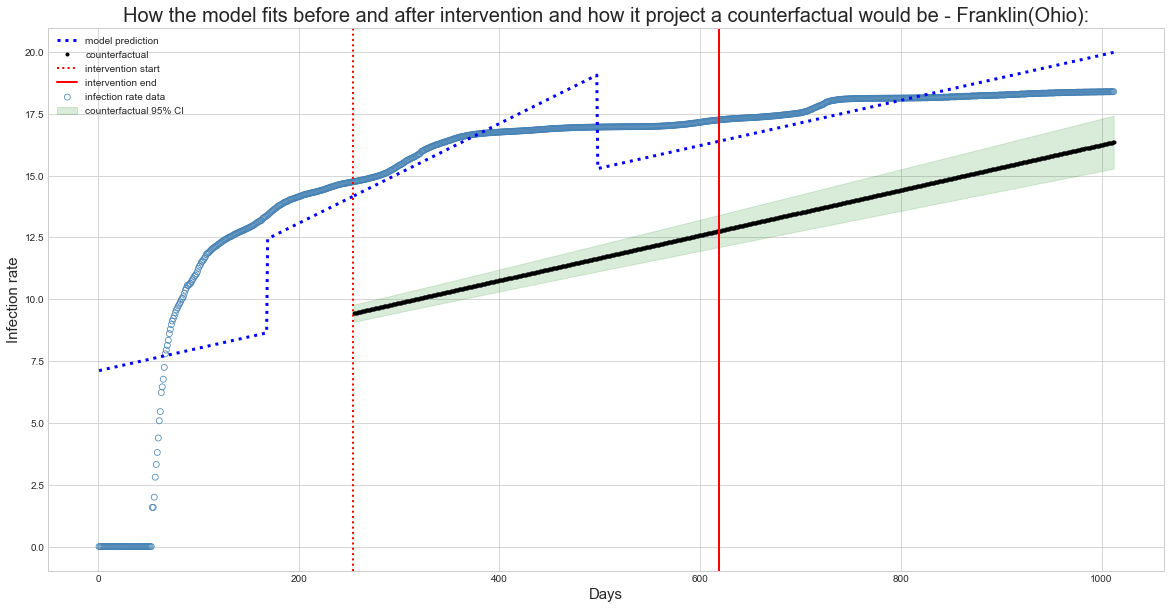

In [61]:
start = 254 # the day on whcih mask mandate was imolemented
end = 619 # the day on which the mask mandate was removed
beta = res.params

# Get model predictions and 95% confidence interval
predictions = res.get_prediction(df_combined)
summary = predictions.summary_frame(alpha=0.05)

# mean predictions
y_pred = predictions.predicted_mean

# countefactual assumes no interventions
cf_df = df_combined.copy()
cf_df["Face_Masks_Required_in_Public"] = 0.0
cf_df["policy_day"] = 0.0

# counter-factual predictions
cf = res.get_prediction(cf_df).summary_frame(alpha=0.05)

# Plotting
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(20,10))

# Plot infection rate data
ax.scatter(df_combined["days"], df_combined["Infections"], facecolors='none', edgecolors='steelblue', label="infection rate data", linewidths=0.75)

# Plot model mean infectionrate prediction
ax.plot(df_combined["days"][:start], y_pred[:start], 'b-', label="model prediction",linestyle='dotted',linewidth=3)
ax.plot(df_combined["days"][start:], y_pred[start:], 'b-',linestyle='dotted',linewidth=3)

# Plot counterfactual mean infection rate with 95% confidence interval
ax.plot(df_combined["days"][start:], cf['mean'][start:], 'k.', label="counterfactual")
ax.fill_between(df_combined["days"][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='g', alpha=0.15, label="counterfactual 95% CI");

# Plot line marking intervention moment
ax.axvline(x = 254, color = 'r', label = 'intervention start', linewidth=2,linestyle='dotted')
# Plot line marking intervention moment
ax.axvline(x = 619, color = 'r', label = 'intervention end',linewidth=2)

ax.legend(loc='best')
plt.title("How the model fits before and after intervention and how it project a counterfactual would be - Franklin(Ohio):",fontsize = 20)
plt.xlabel("Days",fontsize = 15)
plt.ylabel("Infection rate",fontsize = 15);


#### Plotting the distribution of residuals:
The distribution of residuals is an important tool for understanding the accuracy of a model. It can be used to identify potential problems with the model, such as outliers, non-linearity, or heteroscedasticity. Plotting the distribution of residuals can help to identify these issues, as well as to assess the overall accuracy of the model. The distribution of residuals should be approximately normal, with a mean of zero and a standard deviation that is close to the standard error of the model. If the distribution is skewed or has outliers, then the model may need to be adjusted. Additionally, plotting the distribution of residuals can help to identify any patterns in the data that may indicate a need for further investigation.

<AxesSubplot:ylabel='Density'>

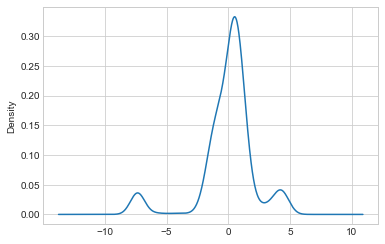

In [31]:
 res.resid.plot(kind="kde")

### Autoregressive model solution
- The autoregressive model specifies that each observation depends linearly on previous observations.

#### To assess how much an observation correlates with past observations it is useful to do an autocorrelation plot as shown below:

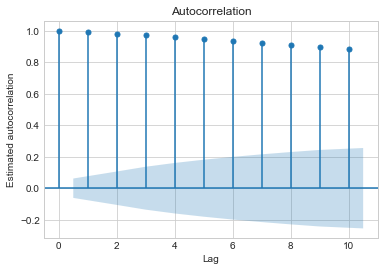

In [32]:
sm.graphics.tsa.plot_acf(res.resid, lags=10)
plt.xlabel("Lag",fontsize = 10)
plt.ylabel("Estimated autocorrelation",fontsize = 10);
plt.show()

#### Partial Autocorrelation
-The partial autocorrelation at lag pp is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

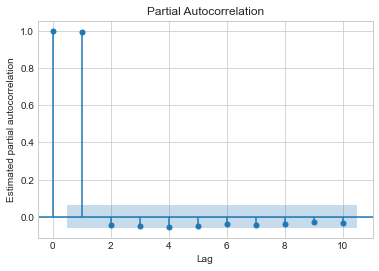

In [33]:
sm.graphics.tsa.plot_pacf(res.resid, lags=10)
plt.xlabel("Lag",fontsize = 10)
plt.ylabel("Estimated partial autocorrelation",fontsize = 10);
plt.show() 

### Model selection 
- The theory states that in an autoregressive model its autocorrelation plot should depict an exponential decay and the number of lags pp should be taken from the partial autocorrelation chart using its pp most relevant lags. Applying the theory to our plots above, we conclude that our model is autoregressive of lag 1 also known as AR(1).

### ARIMA
In statistics ARIMA stands for autoregressive integrated moving average model and as can be inferred by the name AR models are as especial case of ARIMA therefore AR(1) is equivalent to ARIMA(1,0,0).

In [34]:
from statsmodels.tsa.arima.model import ARIMA

arima_results = ARIMA(df_combined["Infections"], df_combined[["days","Face_Masks_Required_in_Public","policy_day"]], order=(1,0,0)).fit()
print(arima_results.summary())


                               SARIMAX Results                                
Dep. Variable:             Infections   No. Observations:                 1012
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1125.945
Date:                Thu, 03 Nov 2022   AIC                          -2239.891
Time:                        16:23:26   BIC                          -2210.373
Sample:                             0   HQIC                         -2228.678
                               - 1012                                         
Covariance Type:                  opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             3.7698     21.397      0.176      0.860     -38.168      45.708
days                              0.0213      0.005      4.150      0.000 

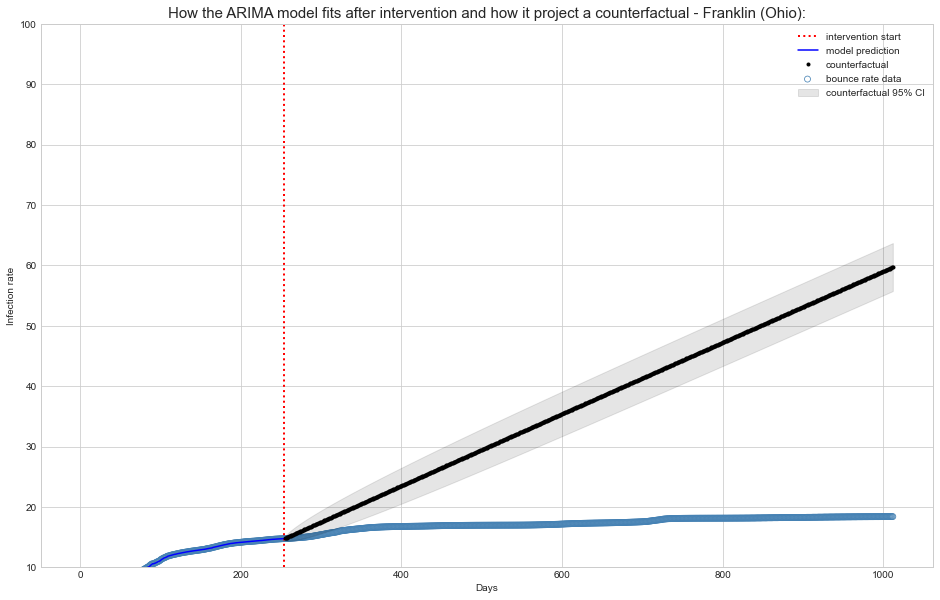

In [60]:
start = 254
end = 619

predictions = arima_results.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.05)

arima_cf = ARIMA(df_combined["Infections"][:start], df_combined["days"][:start], order=(1,0,0)).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(758, exog=df_combined["days"][start:]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

#Plot line marking intervention moment
ax.axvline(x = 254, color = 'r', label = 'intervention start', linewidth=2,linestyle='dotted')



# Plot infection rate data
ax.scatter(df_combined["days"], df_combined["Infections"], facecolors='none', edgecolors='steelblue', label="bounce rate data", linewidths=0.75)

# Plot model mean infection prediction

ax.plot(df_combined["days"][:start], y_pred[:start], 'b-', label="model prediction")
#ax.plot(df_combined["days"][start:], y_pred[start:], 'b-')

# Plot counterfactual mean infection rate with 95% confidence interval
ax.plot(df_combined["days"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_combined["days"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI");

ax.legend(loc='best')
plt.ylim([10, 100])
plt.xlabel("Days")
plt.title("How the ARIMA model fits after intervention and how it project a counterfactual - Franklin (Ohio):",fontsize = 15)
plt.ylabel("Infection rate");



### ARIMA residual analysis
ARIMA residual analysis is a statistical technique used to assess the quality of a model's fit to a time series data. It involves examining the residuals (the difference between the observed values and the predicted values) to determine if there are any patterns that indicate the model is not capturing all of the information in the data. The analysis can help identify any potential problems with the model, such as autocorrelation or heteroscedasticity, and can be used to improve the model's fit.

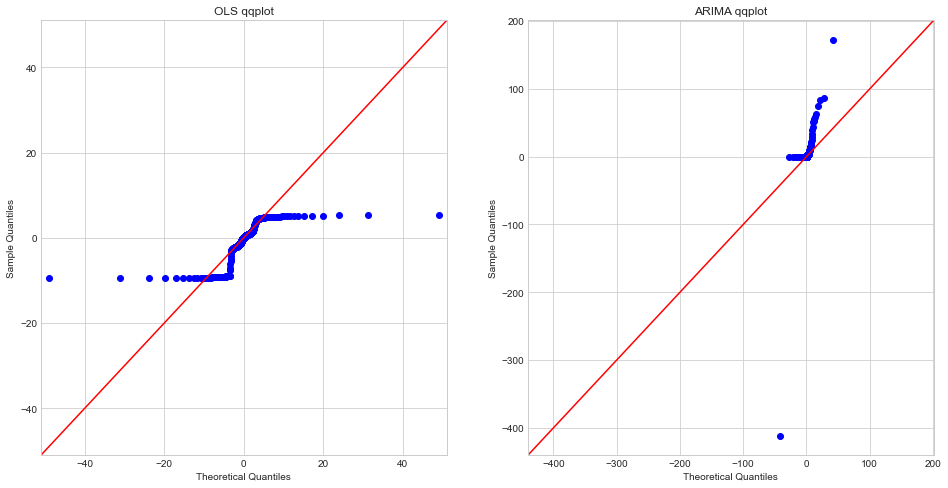

In [51]:
import scipy as sp
from statsmodels.graphics.gofplots import qqplot

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
sm.qqplot(res.resid, sp.stats.t, fit=True, line="45", ax=ax1);
ax1.set_title("OLS qqplot");

sm.qqplot(arima_results.resid, sp.stats.t, fit=True, line="45", ax=ax2);
ax2.set_title("ARIMA qqplot");
plt.show();

### Mask Compliance data
- Based on the mask compliance dafa frame we observed that 61% of the total population ALWAYS wear the mask and roughly around 4.2% population NEVER wears it. Here is an interesting observation that we are finding is that the cureve is getting flattened because very less %age of the population at Franklin in Ohio are not following the compliance and for the RARELY cases it depends on a several factors like where the person went was at a 6feet diatance or was it a shopping mall or departmental store.Additionally, it is important to note that even if everyone wore masks, social distancing and other precautions would still need to be taken in order to prevent the spread of the virus which means that the infection cureve would have never come to zero because there are a number of factors involved in the analysis that are beyond the scope of this assignment

In [56]:
mask_comp = pd.read_csv(DATA_PATH + 'mask_use_by_county.csv')

mask_comp.head(10)

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459
5,1011,0.031,0.040,0.144,0.286,0.500
6,1013,0.102,0.053,0.257,0.137,0.451
7,1015,0.152,0.108,0.130,0.167,0.442
8,1017,0.117,0.037,0.150,0.136,0.560
9,1019,0.135,0.027,0.161,0.158,0.520


In [59]:
mask_comp =mask_comp[mask_comp['COUNTYFP'] == 39049]
mask_comp


,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
2067,39049,0.042,0.054,0.09,0.198,0.617
